In [ ]:
#!pip install datasets

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu 

Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
#!pip install tensorflow-macos tensorflow-metal 

In [4]:
import torch 

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") 

print(f"Using device: {device}") 

Using device: mps


In [5]:
import tensorflow as tf 

print("TF GPU Available:", tf.config.list_physical_devices('GPU')) 

TF GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import torch
from torchvision import transforms
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# load the dataset
ds = load_dataset("docmhvr/powerline-components-and-faults")

print(ds)

print(ds['train'][28])

# function to plot images with bounding boxes
def plot_image_with_bboxes(image, bboxes, labels, ax):
    ax.imshow(image)
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),  
            bbox[2] - bbox[0],  
            bbox[3] - bbox[1],  
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)


num_images_train = len(ds['train'])
print(f"Number of images in the training set: {num_images_train}")




Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['image', 'bboxes', 'labels'],
        num_rows: 1794
    })
    validation: Dataset({
        features: ['image', 'bboxes', 'labels'],
        num_rows: 77
    })
    test: Dataset({
        features: ['image', 'bboxes', 'labels'],
        num_rows: 41
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x321C3EFB0>, 'bboxes': [[304.5, 131.5, 336.5, 536.5]], 'labels': [0]}
Number of images in the training set: 1794


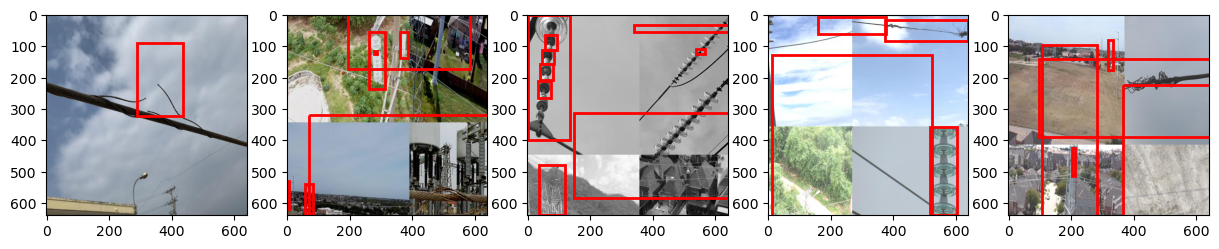

In [ ]:
# plotting the first 5 images with bounding boxes
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image = ds['train'][i]['image']
    bboxes = ds['train'][i]['bboxes']
    labels = ds['train'][i]['labels']
    plot_image_with_bboxes(image, bboxes, labels, axes[i])

plt.show()



In [ ]:
def filter_invalid_bboxes(target):
    #removing bounding boxes with zero width or height, does not work in training
    boxes = target["boxes"]
    valid_indices = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])  # x2 > x1 and y2 > y1
    target["boxes"] = boxes[valid_indices]
    target["labels"] = target["labels"][valid_indices]
    return target


In [ ]:
# define the transformation for images
transform = transforms.Compose([
    transforms.Resize((300, 300)),  #image resizing
    transforms.ToTensor()
])

# process dataset for faster rcnn
def transform_fn(example):
    image = transform(example['image'])  
    target = {}
    target['boxes'] = torch.tensor(example['bboxes'], dtype=torch.float32)
    target['labels'] = torch.tensor(example['labels'], dtype=torch.int64)

    target = filter_invalid_bboxes(target)  

    return image, target


# transforming dataset
dataset = {
    'train': [(transform_fn(ds['train'][i])) for i in range(len(ds['train']))],
    'validation': [(transform_fn(ds['validation'][i])) for i in range(len(ds['validation']))],
    'test': [(transform_fn(ds['test'][i])) for i in range(len(ds['test']))],
}

image, target = dataset['train'][0]
print(f"Image shape: {image.shape}")
print(f"Bounding Boxes: {target['boxes']}")
print(f"Labels: {target['labels']}")


Image shape: torch.Size([3, 300, 300])
Bounding Boxes: tensor([[289.9666,  88.1986, 435.8780, 321.6927]])
Labels: tensor([0])


In [ ]:
from torch.utils.data import Dataset, DataLoader

#custom dataset class for PyTorch
class PowerlineDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]  
#creating dataset objects
train_dataset = PowerlineDataset(dataset['train'])
val_dataset = PowerlineDataset(dataset['validation'])
test_dataset = PowerlineDataset(dataset['test'])

#defining a collate function for batching (since targets are dicts)
def collate_fn(batch):
    images, targets = zip(*batch)  #unzip batch into images and targets
    return list(images), list(targets)

#create and initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

#sample batch
images, targets = next(iter(train_loader))
print(f"Batch size: {len(images)}")
print(f"Image tensor shape: {images[0].shape}")
print(f"Bounding Boxes: {targets[0]['boxes']}")
print(f"Labels: {targets[0]['labels']}")


Batch size: 2
Image tensor shape: torch.Size([3, 300, 300])
Bounding Boxes: tensor([[126.0544, -10.1395, 369.0544,  10.1395],
        [  0.0000, 294.0000, 243.0000, 386.0000],
        [446.7500, 585.5000, 483.2500, 619.5000],
        [415.0000, 294.0000, 530.0000, 640.0000],
        [406.0000, 294.0000, 640.0000, 640.0000]])
Labels: tensor([0, 0, 1, 3, 4])


In [ ]:
#load faster rcnn model (pretrained on coco)
num_classes = len(set([label for _, target in dataset['train'] for label in target['labels']])) + 1  # Add 1 for background

import torchvision.models as models
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

model = models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
#model = torch.compile(model)

#modify classifier for dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features  
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

#move model to gpu if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

print(model)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch.optim as optim

#faster rcnn optimizer definition
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 5 


with progress bar

In [ ]:
from tqdm import tqdm  #progress bar

def train_one_epoch(model, train_loader, optimizer, device, epoch):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    model.to(torch.float32) 




    for images, targets in loop:
        images = [img.to(device, dtype=torch.float16) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        #forward pass
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # update progress bar with current lass
        loop.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)

#training loop
for epoch in range(num_epochs):
    loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss:.4f}")


Epoch 1/5:   0%|          | 0/897 [00:00<?, ?it/s]


RuntimeError: Input type (MPSHalfType) and weight type (MPSFloatType) should be the same

In [ ]:
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            total_loss += loss.item()

    return total_loss / len(val_loader)

# Run validation
val_loss = validate(model, val_loader, device)
print(f"Validation Loss: {val_loss:.4f}")


In [ ]:
torch.save(model.state_dict(), "faster_rcnn_powerlines.pth")
print("Model saved successfully!")
